In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
import shutil
from zipfile import ZipFile
from keras.preprocessing.image import array_to_img, img_to_array, load_img, 

### Loading images

In [145]:
data_folder = os.path.join(os.getcwd(), 'mjsynth','2327', '1')
data_folder_1 = os.path.join(os.getcwd(), 'mjsynth','2327')

file_name = '3_Legumes_44000.jpg'
file_name_complete = os.path.join(data_folder, file_name)

In [146]:
img = load_img(file_name_complete, grayscale=True)
img_array = img_to_array(img)

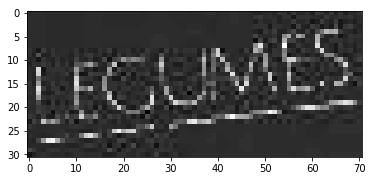

In [147]:
plt.imshow(img_array[:,:,0], cmap='gray')

In [148]:
img_array.shape

(31, 71, 1)

# Pre-processing

#### Reshaping
Converting to (30, 100) grey scale images

In [149]:
from scipy.misc import imresize
from keras.preprocessing.image import ImageDataGenerator
#  reshaping to 32 * 120 images
print ("Original image \t : {0}" .format(img_array.shape))
img_array = imresize(img_array[:,:,0], (32,100)).astype("float32")
print ("Reshaped image \t : {0}" .format(img_array.shape))
img_array = img_array.reshape(32, 100, 1)
print ("Final image \t : {0}" .format(img_array.shape))



Original image 	 : (31, 71, 1)
Reshaped image 	 : (32, 100)
Final image 	 : (32, 100, 1)


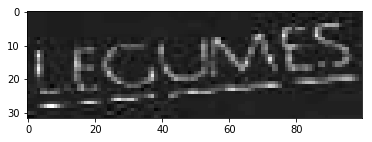

In [150]:
plt.imshow(array_to_img(img_array), cmap='gray')

#### Extracting names

In [137]:
def extract_word(image_name):
    try : 
        out = image_name.split("_")[1]
    except : 
        out = None
    return out

In [138]:
extract_word(file_name)

'Legumes'

#### Data augmentation

In [160]:
from keras.preprocessing.image import ImageDataGenerator

augmenting_datagen = ImageDataGenerator(
    rescale=None,
    rotation_range=None,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest',
)

In [161]:
img_array[ :, :, np.newaxis,].shape

(32, 100, 1, 1)

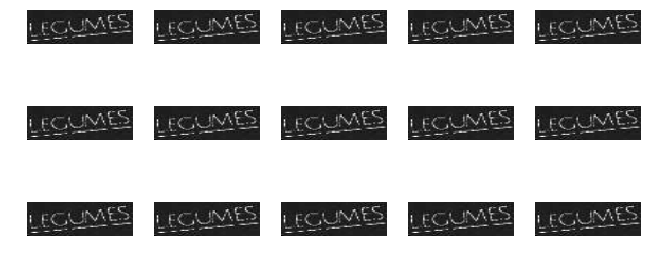

In [162]:
plt.figure(figsize=(11, 5))
flow = augmenting_datagen.flow(img_array[np.newaxis, :, :, :])
for i, x_augmented in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(array_to_img(x_augmented[0]), cmap='gray')
    plt.axis('off')

Found 501 images belonging to 1 classes.


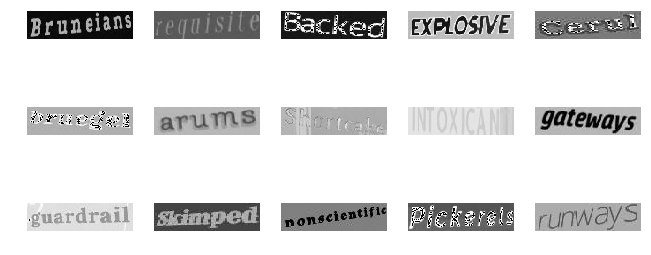

In [165]:
flow = augmenting_datagen.flow_from_directory(
    data_folder_1, batch_size=1, target_size=(32, 120))

plt.figure(figsize=(11, 5))
for i, (X, y) in zip(range(15), flow):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X[0])
    plt.axis('off')

In [166]:
#To do : create 1 folder per class with the name of the class ? 

### Model creation

In [170]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense
from keras.layers import Flatten


convolutions = [64, 128, 256, 512, 512]
kernels = [5, 5, 3, 3, 3]
nb_convo = len(convolutions)

model = Sequential()
input_shape = (30, 100, 1)
for i in range(nb_convo):
    model.add(Conv2D(nb_filter = convolutions[i], \
                     nb_row = kernels[i],\
                     nb_col = kernels[i],\
                     activation ='relu',
                     border_mode='same',
                    input_shape = input_shape, name= "convo"+str(i+1))
             )
    
    if i <= 3 :
        model.add(MaxPooling2D(pool_size=(2, 2), border_mode='same',))

model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dense(4096,activation='relu'))

model.compile(optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'])


In [168]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convo1 (Convolution2D)           (None, 30, 100, 64)   1664        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_6 (MaxPooling2D)    (None, 15, 50, 64)    0           convo1[0][0]                     
____________________________________________________________________________________________________
convo2 (Convolution2D)           (None, 15, 50, 128)   204928      maxpooling2d_6[0][0]             
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 8, 25, 128)    0           convo2[0][0]                     
___________________________________________________________________________________________